In [2]:
# Annulus_Simple_Matplotlib
# mjm June 20, 2016
#
# solve Poisson eqn with Vin = V0 and Vout = 0 for an annulus
# with inner radius r1, outer radius r2
# Vin = 10, Vout =0
#
from dolfin import *
from mshr import *  # need for Circle object to make annulus 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
#parameters["plotting_backend"] = "matplotlib"
import logging
logging.getLogger("FFC").setLevel(logging.WARNING)
#from matplotlib import cm
%matplotlib inline

# Commands for plotting
These are used so the the usual "plot" will use matplotlib.

In [3]:
# commands for plotting, "plot" works with matplotlib 
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))
# end of commands for plotting

# Annulus 
This is the field in an annulus. We specify boundary conditions and solve the problem.

In [4]:
r1 = 1    # inner circle radius
r2 = 10   # outer circle radius

# shapes of inner/outer boundaries are circles
c1 = Circle(Point(0.0, 0.0), r1)
c2 = Circle(Point(0.0, 0.0), r2)

domain = c2 - c1  # solve between circles
res = 20
mesh = generate_mesh(domain, res)

class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1e-2
		return on_boundary and (abs(sqrt(x[0]*x[0] + x[1]*x[1])) - r2) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1e-2
		return on_boundary and (abs(sqrt(x[0]*x[0] + x[1]*x[1])) - r1) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
outerradius.mark(boundaries,2)
innerradius.mark(boundaries,1)

V = FunctionSpace(mesh,'Lagrange',1)

n = Constant(10.0) 

bcs = [DirichletBC(V, 0, boundaries, 2),
	   DirichletBC(V, n, boundaries, 1)]
#	   DirichletBC(V, nx, boundaries, 1)]

u = TrialFunction(V)

v = TestFunction(V)
f = Constant(0.0)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx

u = Function(V)
solve(a == L, u, bcs)


# Plotting with matplotlib
Now the usual "plot" commands will work for plotting the mesh and the function.

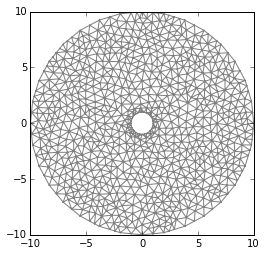

In [5]:
plot(mesh)  # usual Fenics command, will use matplotlib

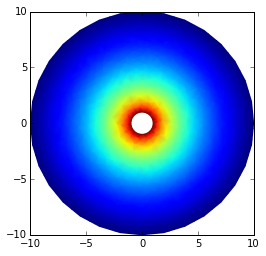

In [6]:
plot(u)     # usual Fenics command, will use matplotlib

If you want to do usual "matplotlib" stuff then you still need "plt." prefix on commands.

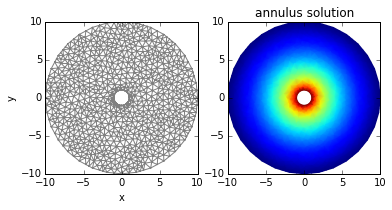

In [7]:
plt.figure()
plt.subplot(1,2,1)
plot(mesh)
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plot(u) 
plt.title('annulus solution')

# Plotting along a line
It turns out the the solution "u" is a function that can be evaluated at a point.  So in the next cell we loop through a line and make a vector of points for plotting. You just need to give it coordinates $u(x,y)$.

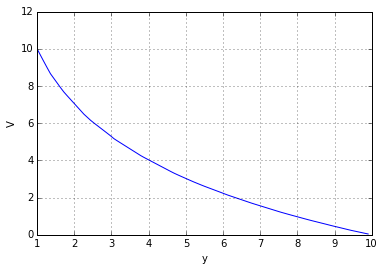

In [8]:
y = np.linspace(r1,r2*0.99,100)
uu = []
np.array(uu)
for i in range(len(y)):
    yy = y[i]
    uu.append(u(0.0,yy)) #evaluate u along y axis
plt.figure()
plt.plot(y,uu)
plt.grid(True)
plt.xlabel('y')
plt.ylabel('V')

In [10]:
u